In [10]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.svm import SVC
from gensim import parsing
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
import chardet
from sklearn.metrics import roc_curve,roc_auc_score,confusion_matrix,classification_report

In [11]:
#mendeteksi encoding dari csv file
with open('spam.csv', 'rb') as f:
    result = chardet.detect(f.read())
    
#menempatkan file csv pada dataframe
df = pd.read_csv("spam.csv", encoding = result['encoding'])

df = df.drop(["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis=1)
df['v1'] = df.v1.map({'ham':0, 'spam':1})

In [12]:
df.isnull().sum()

v1    0
v2    0
dtype: int64

In [13]:
#menghitung data tiap label
df.v1.value_counts()

0    4825
1     747
Name: v1, dtype: int64

In [14]:
import plotly.offline as py
import plotly.graph_objs as go

import numpy as np
random_color=list(np.random.choice(range(255),size=3))

species_count = df['v1'].value_counts()
dfp = [go.Bar(
    x = species_count.index,
    y = species_count.values,
    marker = dict(color = random_color)
)]

py.iplot(dfp)

In [15]:
def parse(s):
    parsing.stem_text(s)
    return s

#parsing terhadap comment
for i in range(0,len(df)):
    df.iloc[i,1]=parse(df.iloc[i,1])
    df.iloc[i,1]=df.iloc[i,1].lower()
X, y = df['v2'].tolist(), df['v1'].tolist()

#split train dan test set 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [16]:
#gunakan pipeline untuk melakukan langkah-langkah secara berurutan dengan satu objek, kali ini kita akan menggunakan pengklasifikasi SVM dengan kernel polinomial
text_clf = Pipeline([('vect', CountVectorizer()), ('tfidf', TfidfTransformer()), ('clf', SVC(kernel='poly'))])

#train model
text_clf.fit(X_train, y_train)

#memprediksi kelas dari data test 
predicted = text_clf.predict(X_test)

print("Accuracy Score : ", accuracy_score(y_test, predicted))

Accuracy Score :  0.9468772433596554


In [17]:
cm = confusion_matrix(y_test, predicted)

from sklearn.metrics import classification_report
print(classification_report(y_test,predicted))

              precision    recall  f1-score   support

           0       0.94      1.00      0.97      1215
           1       1.00      0.58      0.74       178

    accuracy                           0.95      1393
   macro avg       0.97      0.79      0.85      1393
weighted avg       0.95      0.95      0.94      1393



<AxesSubplot:>

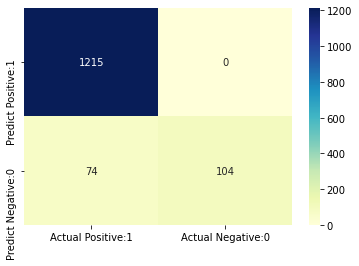

In [18]:
import seaborn as sns # for statistical data visualization

cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'], 
                                 index=['Predict Positive:1', 'Predict Negative:0'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')


In [19]:
random_probs = [0 for _ in range(len(y_test))]
svm_probs = text_clf.predict(X_test)

In [20]:
svm_probs

array([0, 0, 0, ..., 0, 0, 0])

In [21]:
random_auc = roc_auc_score(y_test, random_probs)
svm_auc = roc_auc_score(y_test, svm_probs)

print('Random Prediction : AUCROC = %.3f' % (random_auc))
print('SVM : Score AUCROC = %.3f' % (svm_auc))

Random Prediction : AUCROC = 0.500
SVM : Score AUCROC = 0.792


In [22]:
random_fpr, random_tpr, _ = roc_curve(y_test, random_probs)
svm_fpr, svm_tpr, _ = roc_curve(y_test, svm_probs)

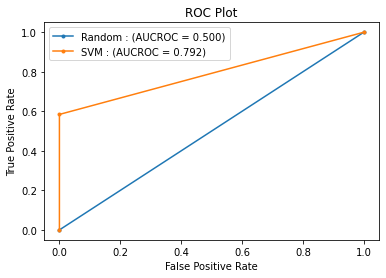

In [23]:
import matplotlib.pyplot as plt
plt.plot(random_fpr, random_tpr, marker='.', label='Random : (AUCROC = %.3f)' % random_auc)
plt.plot(svm_fpr, svm_tpr, marker='.', label='SVM : (AUCROC = %.3f)' % svm_auc)

plt.title('ROC Plot')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()